In [1]:
# General imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import experimentdataanalysis.analysis.dataframe_plotting as dfplot

In [2]:
# import jtplot submodule from jupyterthemes IF installed
import importlib
jtplot_found = importlib.util.find_spec("jupyterthemes.jtplot") is not None
if jtplot_found:
    from jupyterthemes import jtplot
    # - currently installed theme will be used to
    jtplot.style(ticks=False, grid=False, fscale=1.6)
    # set the default figure size
    jtplot.figsize(x=6., y=6.)
    # needed to avoid spurious error messages with imshow...
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
    

In [3]:
import experimentdataanalysis.data_io.metadataparsing as metadataparsing

def parse_filepath_and_header(filepath, header_string=None,
                              parsing_keyword_lists=None,
                              existing_metadata_dict=None):
    if existing_metadata_dict is None:
        existing_metadata_dict = {}
    metadata_dict = metadataparsing.analyze_scan_filepath(filepath,
                                                          existing_metadata_dict,
                                                          parsing_keyword_lists)
    if header_string is not None:
        metadataparsing.analyze_string_for_dict_pairs(header_string, metadata_dict)
    return metadata_dict

def import_csv_files_in_directory_as_df(parent_dir,
                                        run_criteria='directory',
                                        parsing_keyword_lists=None,
                                        metadata_processing_fcns=[],
                                        filter_fcns=[],
                                        pandas_read_csv_kwargs={}):
    """Searches given directory for data files and parses them into
    pandas dataframes using pandas' read_csv function."""
    # LOAD AND NOMINALLY FILTER DATA:
    unfiltered_filepath_list = []
    for dirpath, dirnames, filenames in os.walk(parent_dir):
        for filename in filenames:
            if filename_key in filename:
                unfiltered_filepath_list.append(os.path.join(dirpath, filename))
    if run_criteria is not 'directory':
        raise NotImplementedError("currently only supported run " +
                                  "criteria is grouping-by-directory")
    num_headerlines = pandas_read_csv_kwargs['skiprows']
    last_dir = ''
    run_counter = -1
    filtered_file_list_index = 0
    filtered_filepath_list = []
    file_metadata_list = []
    file_dataframes_list = []
    for filepath in unfiltered_filepath_list:
        with open(filepath) as file_lines_iterator:
            try:
                header_lines = [next(file_lines_iterator)
                                for line in range(num_headerlines)]
            except StopIteration:
                print("tried to skip {} header lines, ".format(num_headerlines) +
                      "but file was too short")
                continue
            file_metadata = parse_filepath_and_header(filepath,
                                                      ''.join(header_lines),
                                                      parsing_keyword_lists)
            file_dataframe = pd.read_csv(filepath_or_buffer=file_lines_iterator,
                                         **pandas_read_csv_kwargs)
            for metadata_processing_fcn in metadata_processing_fcns:
                metadata_processing_fcn(file_metadata)
            if not all([filter_fcn(file_metadata) for filter_fcn in filter_fcns]):
                continue
            file_dataframe['file_index'] = filtered_file_list_index

            # determine Run ID
            if run_criteria == 'directory':
                current_dir = filepath.split('\\')[-2]
                if current_dir != last_dir:
                    last_dir = current_dir
                    run_counter += 1
                file_metadata['Run ID'] = run_counter

            filtered_filepath_list.append(filepath)
            file_dataframes_list.append(file_dataframe)
            file_metadata_list.append(file_metadata)
            filtered_file_list_index += 1
    return filtered_filepath_list, file_dataframes_list, file_metadata_list




In [4]:
import os

# REQUIRED: directory containing 2D scans
parent_dir = ('C:\\Data\\feb_data')
# parent_dir = ('C:\\Data\\FitTrialData2\\Delay_Scan')

# REQUIRED: data storage format information
delimiter = '\t'
trailing_delimiters = True  # rows end in delimiters
num_headerlines = 2
column_names_row = 0  # NOT counting skipped lines from num_headerlines
overwriting_column_names = []

if not overwriting_column_names:
    overwriting_column_names = None
pandas_read_csv_kwargs = {
     'skiprows': num_headerlines,
     'header': column_names_row,
     'names': overwriting_column_names,
     'delimiter': delimiter,
}
if trailing_delimiters:  # needed to avoid problems
    pandas_read_csv_kwargs['index_col'] = False

# REQUIRED: filename key for data files, will load only these
filename_key = '.dat'

# REQUIRED: criteria for grouping runs
run_criteria = 'directory'

# OPTIONAL: filepath parsing rules
# DEFAULT SEARCH TERMS AND SEARCH RULES:
# 1. If first string found, register second string as
#    tag containing third string/value
#        e.g. if keyword_list contains ("warmup", "Warmup?", "Yes"):
#             "...warmup..." -> {"Warmup?": "Yes"}
this_element_keyword_list = [("TRKR", "IsTRKR?", True),
                             ("RSA", "IsRSA?", True),
                            ]
# 2. Grab next element(s) if this one CONTAINS first string,
#    tag next element(s) as second string(s)
#        e.g. "..._Ind_3_..." -> {"FastScanIndex": 3}
#        e.g. "..._2Dscan_MirrorY_MirrorZ_..."
#                 -> {"SecondScanType": "MirrorY",
#                     "FirstScanType": "MirrorZ"}
next_element_keyword_list = [("Ind", "Scan_2D_Index"),
                             ("2Dscan", ["Scan_2D_Type", "Scan_1D_Type"]),
                            ]
# 3. Grab this element if it CONTAINS first string,
#    tag remainder as second string
#        e.g. "..._30K_..." -> {"SetTemperature": 30}
in_this_element_keyword_list = [("Vcm", "Electric Field (V/cm)"),
                                ("mT", "Magnetic Field (mT)"),
                                ("K", "Set Temperature (K)"),
                                ("nm", "Wavelength (nm)"),
                                ("ps", "Delay Time (ps)"),
                                ("V", "Voltage (V)"),
                                ("x", "Scan_2D_Coord"),
                                ("uWpump", "Pump Power (uW)"),
                                ("uWprobe", "Probe Power (uW)"),
                                ("repeats", "# repeats"),
                               ]
parsing_keyword_lists = [this_element_keyword_list,
                         next_element_keyword_list,
                         in_this_element_keyword_list]

# OPTIONAL: metadata processing functions,
# must accept dict and modify in-place
def consolidate_aliases_for_bfield(metadata_dict):
    if 'BExternal' in metadata_dict.keys():
        metadata_dict['Magnetic Field (mT)'] = metadata_dict['BExternal']
def process_2DScan_filename_format(metadata_dict):
    if {'Scan_2D_Type', 'Scan_2D_Coord'}.issubset(metadata_dict.keys()):
        metadata_dict[metadata_dict['Scan_2D_Type']] = metadata_dict['Scan_2D_Coord']
metadata_processing_fcns = [consolidate_aliases_for_bfield,
                            process_2DScan_filename_format]

# OPTIONAL: metadata-based filtering fcns, type: dict() -> bool
# fcns returning False if data should be ignored
filter_fcns = [
#                lambda metadata_dict: metadata_dict.get("# repeats", 1) <= 2,
               lambda metadata_dict: "alignment" not in metadata_dict.get("Filepath"),
               lambda metadata_dict: "Scan_2D_Index" in metadata_dict.keys(),
               lambda metadata_dict: \
                   "TRKR_PhaseTracking_from110mT" in metadata_dict.get("Filepath"),
              ]

filepath_list, file_dataframes_list, file_metadata_list = \
    import_csv_files_in_directory_as_df(parent_dir, run_criteria,
                                        parsing_keyword_lists,
                                        metadata_processing_fcns,
                                        filter_fcns,
                                        pandas_read_csv_kwargs)


In [5]:
index = 0
for key, val in file_metadata_list[index].items():
    print("{}: {}".format(key, val))
file_dataframes_list[index].head()

Scan_2D_Coord: 0.113
Scan_1D_Type: DelayTime
Key: Value
Wavelength (nm): 816.48
Filepath: C:\Data\feb_data\170219\TRKR_PhaseTracking_from110mT___816.48nm_10K_2Dscan_BExternal_DelayTime\Ind_10_DelayTime -500_to_200 BExternal 0.113x.dat
Scan_2D_Type: BExternal
BExternal: 0.113
IsTRKR?: True
Scan_2D_Index: 10.0
Set Temperature (K): 10.0
Run ID: 0
File Last Modified: Sun Feb 19 21:40:22 2017


,scancoord,lockin2x,lockin1x,lockin2r,lockin1r,laserpower,cwetalon,lasercomponent1,lasercomponent2,temperature,file_index
0,-500.0554,0.001004,-0.00610,0.009924,0.00635,0.796,-0.188,0.9118,0.0010,9.993,0
1,-450.1939,0.008830,-0.00565,0.000877,0.00580,0.793,-0.197,0.0330,-0.0030,10.003,0
2,-400.0554,0.006677,0.00405,0.005572,0.00400,0.796,-0.173,0.0020,-0.1556,9.990,0
3,-350.2493,0.000430,0.01565,0.006636,0.01560,0.794,-0.173,9.9110,0.0010,10.001,0
4,-300.0554,0.000422,0.02720,0.000488,0.02720,0.797,-0.210,0.0110,-0.0080,9.992,0


In [6]:
# pare down to just data columns what we care about
# but add all relevant metadata as columns itself

# SEMI-REQUIRED: column-generation options for INDIVIDUAL DATA FILES.
info_tag_to_column_list = [('BExternal', 'b_external'),
                           ('Run ID', 'run_id'),
                           ('Scan_2D_Index', 'index_2d'),
                           ('Pump Power (uW)', 'pump_power'),
                           ('Wavelength (nm)', 'wavelength'),
                          ]
column_expression_list = [
                          'index_2d = index_2d - 1',  # filenames start  @1, not @0
                          'index_1d = index',
                         ]

# OPTIONAL: specification of specific columns in data file as x-coords, y-coords. 
#           default: X = 1st column in file, Y = 2nd column in file. 
#                    (or in terms of resulting DataFrame, X = index, Y = 1st column)
data_xfield = None
data_yfield = 'lockin1x'

dataframes_list = []
for file_info_dict, file_dataframe in zip(file_metadata_list, file_dataframes_list):
    column_names = file_dataframe.columns.values.tolist()
    if data_xfield is None:
        data_xfield = column_names[0]
    if data_yfield is None:
        data_yfield = column_names[1]

    # create new dataframe based on user specifications:
    new_dataframe = pd.DataFrame(file_dataframe,
                                 columns=[data_xfield, data_yfield, 'file_index'])
    for info_tag, column_name in info_tag_to_column_list:
        if info_tag in file_info_dict:
            new_dataframe[column_name] = file_info_dict[info_tag]
    for expression in column_expression_list:
        new_dataframe.eval(expression, inplace=True)

    # add new dataframe to list
    dataframes_list.append(new_dataframe)

full_dataframe = pd.concat(dataframes_list)

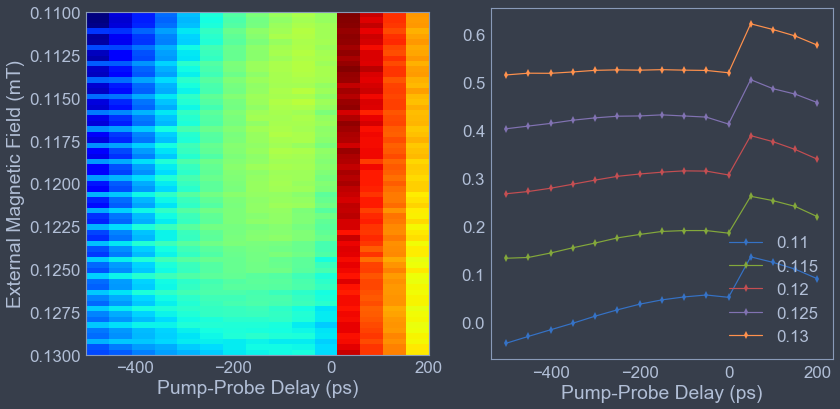

probe_delay  kerr_rotation  file_index  b_external  \
run_id index_2d index_1d                                                       
0      0.0      0         -500.055400       -0.04480          10        0.11   
                1         -450.193900       -0.03055          10        0.11   
                2         -400.055400       -0.01670          10        0.11   
                3         -350.249300       -0.00305          10        0.11   
                4         -300.055400        0.01170          10        0.11   
                5         -250.193900        0.02485          10        0.11   
                6         -200.055400        0.03665          10        0.11   
                7         -150.249300        0.04565          10        0.11   
                8         -100.055400        0.05180          10        0.11   
                9          -50.193900        0.05585          10        0.11   
                10          -0.055402        0.05100          10        0.11   
                11          49.806100        0.13545          10        0.11   
                12          99.944600        0.12400          10        0.11   
                13         149.806100        0.10980          10        0.11   
                14         199.889200        0.08975          10        0.11   
       1.0      0         -500.055400       -0.04485          21        0.11   
                1         -450.193900       -0.03190          21        0.11   
                2         -400.055400       -0.01720          21        0.11   
                3         -350.249300       -0.00420          21        0.11   
                4         -300.055400        0.01065          21        0.11   

                          wavelength  
run_id index_2d index_1d              
0      0.0      0             816.48  
                1             816.48  
                2             816.48  
                3             816.48  
                4             816.48  
                5             816.48  
                6             816.48  
                7             816.48  
                8             816.48  
                9             816.48  
                10            816.48  
                11            816.48  
                12            816.48  
                13            816.48  
                14            816.48  
       1.0      0             816.48  
                1             816.48  
                2             816.48  
                3             816.48  
                4             816.48

In [21]:
df = full_dataframe.copy()
df.rename(columns={'scancoord': 'probe_delay',
                   'lockin1x':  'kerr_rotation'}, inplace=True)
df.set_index(['run_id', 'index_2d', 'index_1d'], drop=True, append=False, inplace=True)
df.sort_index(ascending=True, inplace=True)
df.head(20)

# plot newly created dataframe and show the first few rows
waterfall_plot_indices = [0, 15, 30, 45, 60]
plt.figure(figsize=(12,6))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

last_zval = 0
for axes_ind, df_index in enumerate(waterfall_plot_indices):
#     wf_ax = plt.subplot(len(waterfall_plot_indices), 2,
#                         2 * (axes_ind + 1))
    wf_ax = ax2
#     df.loc[0,df_index].plot(x='probe_delay',
#                             y='kerr_rotation',
#                             kind='line', ax=wf_ax)
    xvals = df.loc[0, df_index]['probe_delay']
    yvals = df.loc[0, df_index]['b_external']
    zvals = df.loc[0, df_index]['kerr_rotation'] + last_zval
    last_zval = max(zvals)
    ax2.plot(xvals, zvals, 'd-', label=str(yvals[0]))
ax2.legend()
ax2.set_xlabel('Pump-Probe Delay (ps)')

dfplot.plot_dataframe_2d(df, 'kerr_rotation',
                         x_values_column='probe_delay',
                         y_values_column='b_external',
                         ax=ax1, aspect=1.0)
ax1.set_xlabel('Pump-Probe Delay (ps)')
ax1.set_ylabel('External Magnetic Field (mT)')
# dfplot.plot_dataframe_2d(df, 'kerr_rotation',
#                          x_values_column='probe_delay',
#                          y_values_column='b_external',
#                          ax=ax2, aspect=1.0)
plt.show()
df.head(20)